In [1]:
#%load_ext lab_black
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Linear City Model

In [2]:
def drawConsumer (register, L:int=1, fixLocation=None):
    """L: number of goods"""
    c = {
        "id": register["consumerId"]+1, 
        "type": "consumer",
        "wealth": 2 + np.random.rand()*2,
        "talent": 2 + np.random.rand()*2,
        "taste": np.random.rand(L),
        "mc_transport": 0.025,
        'supplierId': None,
        'location': fixLocation,
        'mortgage': 0,
        'surplus': 0
    }
    register["consumers"][c["id"]] = c
    register["consumerId"] += 1
    return(c)

In [3]:
def drawFirm (register, L:int=1, fixLocation=None):
    f = {
        "id": register["firmId"]+1, 
        "type": "firm",
        "mc": np.random.rand()/4,
        "good": np.random.randint(0,L),
        'clients': set(),
        'location': fixLocation,
        'mortgage': 0,
        'surplus': 0
    }
    register["firms"][f["id"]] = f
    register["firmId"] += 1
    return(f)

In [4]:
def floorCost (lvl: int):
    """returns cost for moving into floor lvl x"""
    cost = 0 + lvl ** 1.2 / 10
    return(cost)

list(map(lambda x: round(floorCost(x),2), range(10)))

[0.0, 0.1, 0.23, 0.37, 0.53, 0.69, 0.86, 1.03, 1.21, 1.4]

In [5]:
def consumerValue(consumer, firm):
    value = consumer["taste"][firm["good"]] * consumer["wealth"]
    value -= firm["mc"]
    value -= consumer["mc_transport"] * abs(consumer["location"] - firm["location"]) 
    return(value)
# 

In [6]:

def returnMaxIndex (numbers: list):
    """Return maximum index. If maximum is not unique, choose randomly among maxima."""
    # find all choice options with best value
    numberIsMax = [x == max(numbers) for x in numbers]
    # randomly choose one of them and return index
    maxInd = [c for (c, m) in zip(range(len(numberIsMax)), numberIsMax) if m][np.random.randint(0, sum(numberIsMax))]
    return maxInd
# 

In [7]:
def chooseSupplier (register:dict, consumer:dict):
    # consumer location must be given
    supplierId = consumer["supplierId"]
    currentValue = -100

    for firmId in register["firms"].keys():
        firm = register["firms"][firmId]
        if(firm["location"] != None):
            if(consumerValue(consumer, firm)>currentValue):
                supplierId = firm["id"]
                currentValue = consumerValue(consumer, firm)

    return supplierId
# 

In [8]:
def removeFromFirm (register:dict, consumer:str):
    firms = register["firms"]
    firmId = consumer["supplierId"]
    if(firmId != None and firmId in firms.keys() and consumer["id"] in firms[firmId]["clients"]):
        firms[firmId]["clients"].discard(consumer["id"])
        firms[firmId]['surplus'] -= (max(0, consumer['surplus'] - (consumer['mortgage']) - firms[firmId]["mc"])) # how is welfare shared    


In [9]:
def assignToFirm(register:dict, consumer:dict, firmId:str): 
    firms = register["firms"]
    removeFromFirm(register, consumer)

    consumer["supplierId"] = firmId 

    if(firmId in firms.keys()):
        firms[firmId]["clients"].add(consumer["id"]) 
        firms[firmId]['surplus'] += max(0, consumer['surplus'] - consumer['mortgage'] - firms[firmId]["mc"]) # how is welfare shared 

#

In [10]:
def settleConsumer (city:list, register:dict, consumer:dict, relocate:bool=False, fixedPosition:int=-1):
    firms = register["firms"]
    if(relocate):
        city[consumer["location"]].remove(consumer)
        removeFromFirm(register, consumer["id"])
        consumer['mortgage'] *= 0
        consumer['surplus'] *= 0

    # give a value to each possible settlement position
    locationValues = list(map(lambda x: -floorCost(len(x)), city))
    locationSuppliers = [consumer["supplierId"]]*len(city)
    if(len(firms)>0):
        for locationInd, location in enumerate(city):
            consumer["location"] = locationInd
            locationSupplier = firms[chooseSupplier(register, consumer)]
            locationValues[locationInd] = consumerValue(consumer, locationSupplier) - floorCost(len(location))
            locationSuppliers[locationInd] = locationSupplier['id']
        
    if(max(locationValues)>0):
        locationInd = fixedPosition if(fixedPosition >= 0) else returnMaxIndex(locationValues)
        consumer['location'] = locationInd
        consumer['mortgage'] = -floorCost(len(city[locationInd]))
        consumer['surplus'] = max(locationValues)

        assignToFirm(register, consumer, locationSuppliers[locationInd])
        city[locationInd].append(consumer)
    # else:
    #     print('Consumer wont settle in city', max(locationValues)<0)
    #     #register["consumers"].remove(consumer)
        
#

In [11]:
def settleFirm(city:list, register, firm:dict, relocate:bool=False, fixedPosition:int=-1): 
    consumers = register["consumers"]
    firms = register["firms"]
    if(relocate):
        city[firm["location"]].remove(firm)
        for client in firm["clients"]:
            firm = chooseSupplier(register, client)
            assignToFirm(register, client, firm["id"])


    locationValues = list(map(lambda x: -floorCost(len(x)), city)) 
    locationClients = [[]]*len(city)

    for locationInd, location in enumerate(city):
        firm["location"] = locationInd
        for consumerId in consumers.keys():
            consumer = consumers[consumerId]
            
            if( consumer["supplierId"] == None or consumerValue(consumer, firms[consumer["supplierId"]] ) < consumerValue(consumer, firm) ):
                        locationValues[locationInd] += max(0, consumerValue(consumer, firm) - firm["mc"]) # how is welfare shared 
                        locationClients[locationInd].append(consumer["id"])

    # locate firm at maximum location index
    locationInd = fixedPosition if(fixedPosition >= 0) else returnMaxIndex(locationValues)
    firm["location"] = locationInd
    firm['mortgage'] = -floorCost(len(city[locationInd]))
    firm['surplus'] = max(locationValues)

    for clientId in locationClients[locationInd]:
        assignToFirm(register, consumers[clientId], firm["id"])
       
    city[locationInd].append(firm) 

#

In [12]:
def createNewCity (L, size:int=100, firmPositions:list=[range(0)], consumerPositons:list=[range(0)]):
    register = {
        "consumers": {},
        "firms" : {},
        "consumerId": 0,
        "firmId": 0,
    }

    city = list(map(lambda x: [], [1]*size))
    
    for positions in firmPositions:
        positions = list(positions)
        for pos in positions:
            settleConsumer(city, register, drawFirm(register, L, pos), fixedPosition=pos)
            
    for positions in consumerPositons:
        positions = list(positions)
        for pos in positions:
            settleConsumer(city, register, drawConsumer(register, L, pos), fixedPosition=pos)

    return (city, register)

In [13]:
(city, register) = createNewCity(1,10, [],[range(4,5)])
register

{'consumers': {1: {'id': 1,
   'type': 'consumer',
   'wealth': 2.319868993505845,
   'talent': 2.6010431667866567,
   'taste': array([0.47203864]),
   'mc_transport': 0.025,
   'supplierId': None,
   'location': 4,
   'mortgage': -0.0,
   'surplus': -0.0}},
 'firms': {},
 'consumerId': 1,
 'firmId': 0}

Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont settle in city True
Consumer wont 

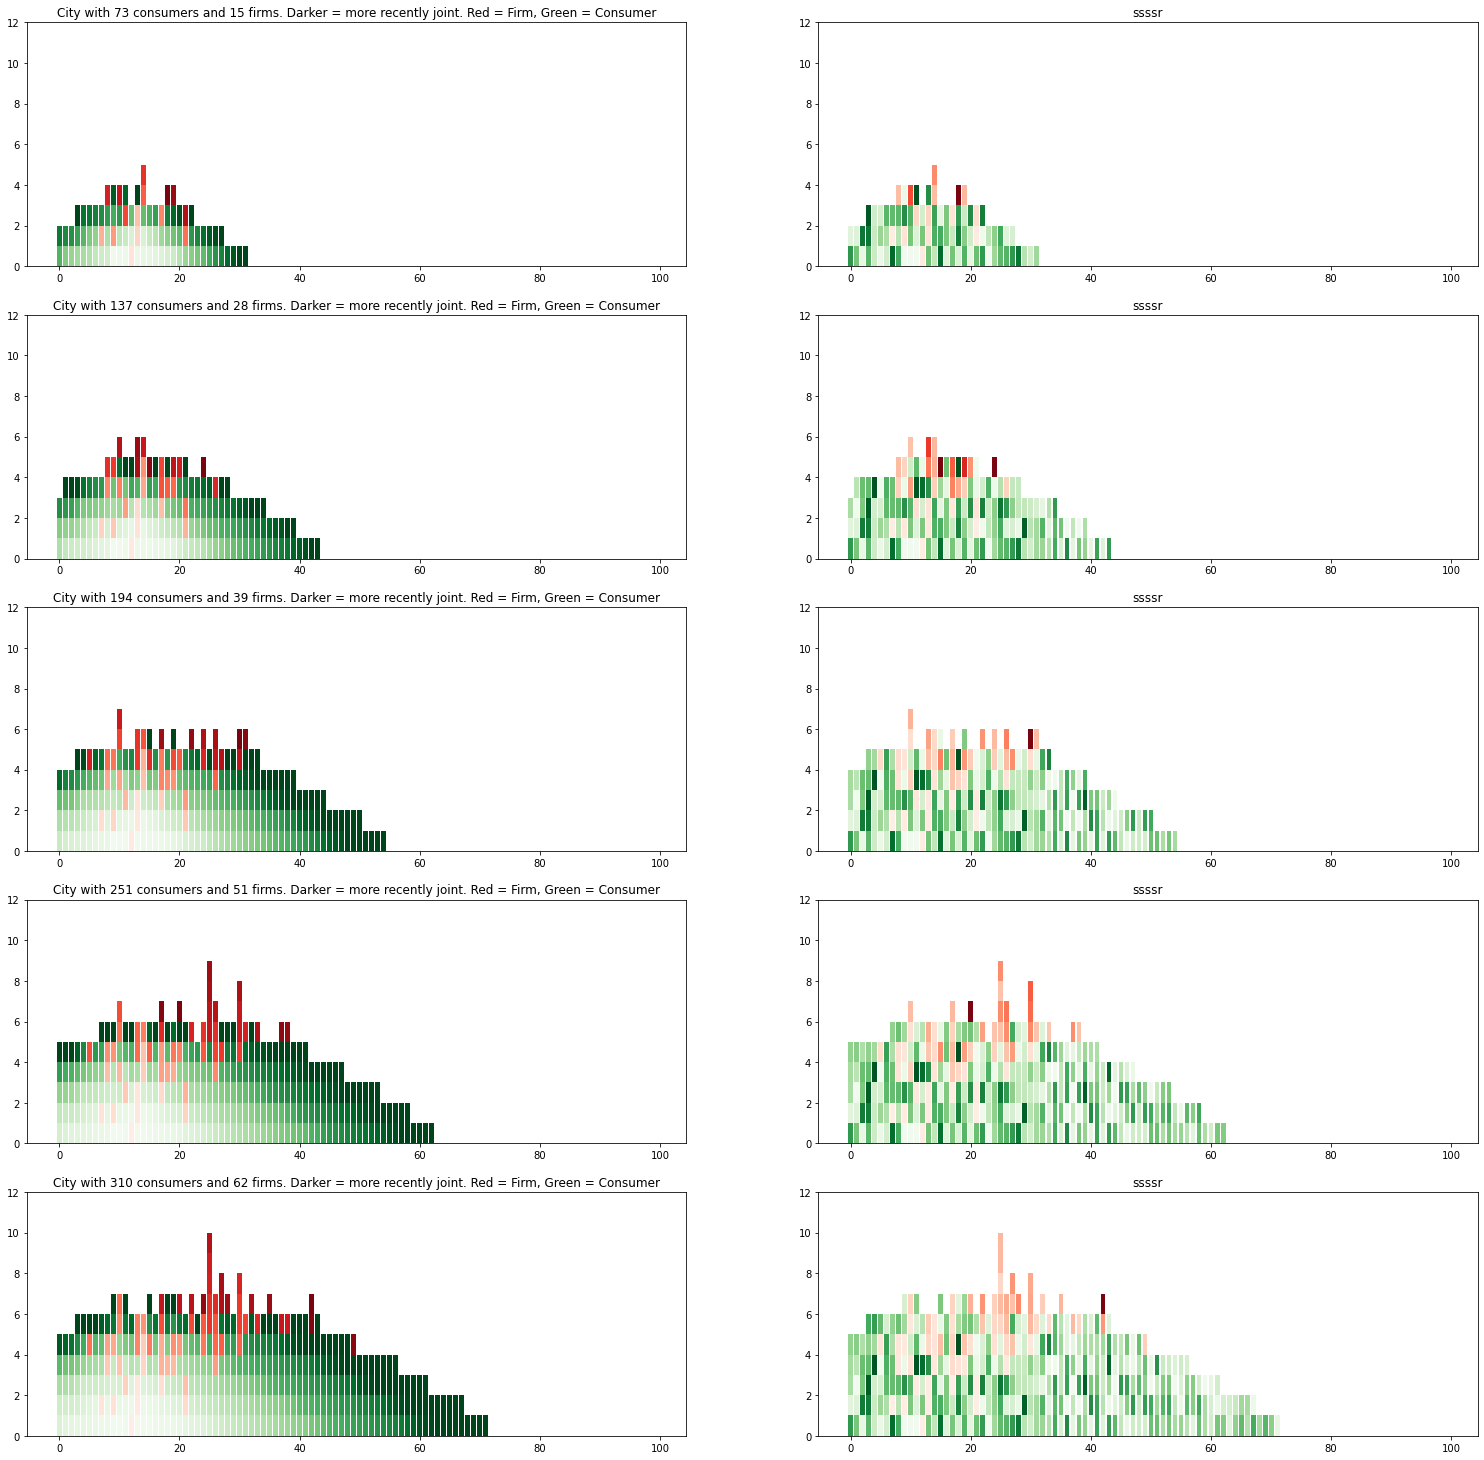

In [14]:
# number of differntiated goods
params = {
    "L":1,
    "citysize": 100,
    "firmPostions_start": [],
    "consumerPositons_start": [range(9,12)],
    "max_pop": 400,
    "firm_to_pop_ratio": 1/5,
    "n_subplots": 5
}
# number of lots in linear city, maximum floor number

(city, register) = createNewCity(L=params["L"], size=params["citysize"], firmPositions=params["firmPostions_start"], consumerPositons=params["consumerPositons_start"])

fig, axs = plt.subplots(nrows=params["n_subplots"], ncols=2, figsize=(26,26))
plt.get_cmap('jet')
for i in range(2*params["max_pop"]+1):
    city_pop = sum(list(map(lambda l: len(list(filter(lambda p: p["type"]=="consumer", l))), city)))
    city_n_firms = sum(list(map(lambda l: len(list(filter(lambda p: p["type"]=="firm", l))), city)))
    if( (city_n_firms / city_pop) < params["firm_to_pop_ratio"] ):
        settleFirm(city, register, drawFirm(register, params["L"]))
        # print("added firm.")
        
    settleConsumer(city, register, drawConsumer(register, params["L"]))
    if(i in list(np.array(range(1,params["n_subplots"] + 1))*(params["max_pop"] / params["n_subplots"]))):
        ax = axs.flat[ 2 * int( (i // (params["max_pop"] / params["n_subplots"]) ) - 1) ] #if params["n_subplots"] > 1 else axs
        labels = range(len(city))
        for locInd, location in enumerate(city):
            for (floor, party) in enumerate(location):
                cn = int(10 + party["id"] * 236 / city_pop) if party["type"]=="consumer" else int(10 + party["id"] * 236 / city_n_firms) 
                
                clr = plt.cm.Greens(cn) if party["type"]=="consumer" else plt.cm.Reds(cn)
                ax.bar(labels, list([0]*(locInd)+[1]+[0]*(params["citysize"]-locInd-1)), bottom=floor, color=clr) 
        # n_firms = list(map(lambda l: len(list(filter(lambda p: p["type"]=="firm", l))),city))
        # n_consumers = list(map(lambda l: len(list(filter(lambda p: p["type"]=="consumer", l))),city))
        # #width = 0.35       # the width of the bars: can also be len(x) sequence
        
        # ax.bar(labels, n_firms, label='firms')
        # ax.bar(labels, n_consumers, bottom=n_firms, label='consumer')
        # ax.bar(labels, n_firms, label='firms')
        # ax.legend()
        # ax.set_ylabel('Scores')
        title = "City with " + str(city_pop) + " consumers and " + str(city_n_firms) + " firms. Darker = more recently joint. Red = Firm, Green = Consumer"
        ax.set_title(title)


        ax = axs.flat[ 1 + 2 * int( (i // (params["max_pop"] / params["n_subplots"]) ) - 1) ] #if params["n_subplots"] > 1 else axs
        labels = range(len(city))
        maxConsumerSurplus = max(list(map(lambda k: register["consumers"][k]["surplus"], register["consumers"].keys())))
        maxFirmSurplus = max(list(map(lambda k: register["firms"][k]["surplus"], register["firms"].keys())))
        for locInd, location in enumerate(city):
            for (floor, party) in enumerate(location):
                cn = int(10 + party["surplus"] * 236 / maxConsumerSurplus) if party["type"]=="consumer" else int(10 + party["surplus"] * 236 / maxFirmSurplus) 
                
                clr = plt.cm.Greens(cn) if party["type"]=="consumer" else plt.cm.Reds(cn)
                ax.bar(labels, list([0]*(locInd)+[1]+[0]*(params["citysize"]-locInd-1)), bottom=floor, color=clr) 
        # n_firms = list(map(lambda l: len(list(filter(lambda p: p["type"]=="firm", l))),city))
        # n_consumers = list(map(lambda l: len(list(filter(lambda p: p["type"]=="consumer", l))),city))
        # #width = 0.35       # the width of the bars: can also be len(x) sequence
        
        # ax.bar(labels, n_firms, label='firms')
        # ax.bar(labels, n_consumers, bottom=n_firms, label='consumer')
        # ax.bar(labels, n_firms, label='firms')
        # ax.legend()
        # ax.set_ylabel('Scores')
        title = "ssssr"
        ax.set_title(title)

ylim = [0, 1 + max(list(map(lambda l: len(l), city)))]
# if(params["n_subplots"] > 1):
for ax in axs.flat:
    ax.set_ylim(ylim)
# else:
#     axs.set_ylim(ylim)
plt.show()
plotName = ""
for key in params.keys():
    plotName += key[0] + str(params[key] )
plotName
fig.savefig(plotName + '.png')


'L1c100f[]c[range(9, 12)]m400f0.2n5'

In [18]:
params.keys()

dict_keys(['L', 'citysize', 'firmPostions_start', 'consumerPositons_start', 'max_pop', 'firm_to_pop_ratio', 'n_subplots'])